In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import math
import datetime

In [2]:
# 再現性のためランダムシード固定
np.random.seed(seed=0)
tensorflow.random.set_seed(seed=0)

In [3]:
base_dir = "./yokohama/"

temperature_csv = "data_temperature.csv"

df_temperature = pd.read_csv(os.path.join(base_dir, temperature_csv), encoding="shift-jis", header=2)


In [4]:
df_temperature.head(10)

,年月日,平均気温(℃),平均気温(℃).1,平均気温(℃).2
0,NaN,NaN,品質情報,均質番号
1,1992/6/18,17.4,8,1
2,1992/6/19,18.8,8,1
3,1992/6/20,17.7,8,1
4,1992/6/21,18.1,8,1
5,1992/6/22,19.0,8,1
6,1992/6/23,16.1,8,1
7,1992/6/24,16.7,8,1
8,1992/6/25,18.1,8,1
9,1992/6/26,20.6,8,1


In [5]:
def df_extract(df):
    return df.iloc[1:, :2]

df_temperature = df_extract(df_temperature)


In [6]:
df_temperature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10228 entries, 1 to 10228
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   年月日      10228 non-null  object 
 1   平均気温(℃)  10228 non-null  float64
dtypes: float64(1), object(1)
memory usage: 159.9+ KB


In [7]:
df_temperature.index = pd.to_datetime(df_temperature['年月日'])
df_temperature.drop('年月日', axis=1, inplace=True)

In [8]:
df_temperature.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10228 entries, 1992-06-18 to 2020-06-18
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   平均気温(℃)  10228 non-null  float64
dtypes: float64(1)
memory usage: 159.8 KB


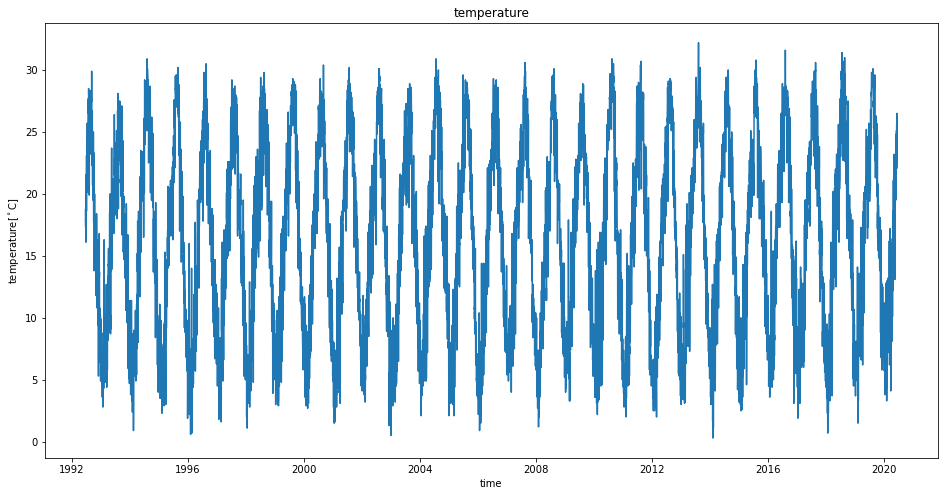

In [9]:
# グラフ化
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

ax.plot(df_temperature.index, df_temperature.values[:, 0])
ax.set_title("temperature")
ax.set_ylabel("temperature[$^\circ$C]")
ax.set_xlabel("time")
    
plt.show()


# 0   平均気温(℃)      10227 non-null  float64


In [10]:
df_temperature

,平均気温(℃)
年月日,
1992-06-18,17.4
1992-06-19,18.8
1992-06-20,17.7
1992-06-21,18.1
1992-06-22,19.0
...,...
2020-06-14,22.4
2020-06-15,26.5
2020-06-16,25.4


In [11]:
def create_dataset(dataset, look_back):
    data_X, data_y = [], []
    for i in range(look_back, len(dataset)):
        data_X.append(dataset[i-look_back:i, :])
        data_y.append(dataset[i, 0])
    return np.array(data_X), np.array(data_y)

# データセットをtrainとtestに分割
div_idx_test = len(df_temperature) * 2 // 3

train, test = df_temperature.values[:div_idx_test, :].copy(), df_temperature.values[div_idx_test:, :].copy()

# trainデータセットからvalidデータを分割
div_idx_valid = len(train)*3//4
train, valid = train[:div_idx_valid, :], train[div_idx_valid:, :]

# データをMinMax
scaler_train_temperature = MinMaxScaler(feature_range=(0, 1))
scaler_train = scaler_train_temperature.fit(np.reshape(train[:, 0], (train.shape[0], 1)))
train[:, 0] = scaler_train.transform(np.reshape(train[:, 0], (train.shape[0], 1))).flatten()
valid[:, 0] = scaler_train.transform(np.reshape(valid[:, 0], (valid.shape[0], 1))).flatten()
test[:, 0] = scaler_train.transform(np.reshape(test[:, 0], (test.shape[0], 1))).flatten()

# 終値をdatasetに変換
look_back = 30
train_X, train_y = create_dataset(train, look_back)
valid_X, valid_y = create_dataset(valid, look_back)
test_X, test_y = create_dataset(test, look_back)

train_X = np.reshape(train_X, (train.shape[0]-look_back, look_back, train.shape[1]))
valid_X = np.reshape(valid_X, (valid.shape[0]-look_back, look_back, valid.shape[1]))
test_X = np.reshape(test_X, (test.shape[0]-look_back, look_back, train.shape[1]))

print(train_X.shape, train_y.shape, valid_X.shape, valid_y.shape, test_X.shape, test_y.shape)

(5083, 30, 1) (5083,) (1675, 30, 1) (1675,) (3380, 30, 1) (3380,)


In [12]:
#train_X

In [13]:
# LSTM
model = Sequential()
model.add(LSTM(80,
               input_shape=(look_back, train.shape[1]),
               recurrent_dropout=0.02))
model.add(Dense(1))

es = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode="min")

model.compile(optimizer='adam', loss='mean_squared_error', lr=1e-3)
model.fit(train_X, train_y,
          epochs=60, 
          batch_size=16, 
          verbose=1, 
          validation_data=[valid_X, valid_y],
          callbacks=[es])


Train on 5083 samples, validate on 1675 samples
Epoch 1/60
5083/5083 [==============================] - 46s 9ms/sample - loss: 0.0107 - val_loss: 0.0074
Epoch 2/60
5083/5083 [==============================] - 24s 5ms/sample - loss: 0.0066 - val_loss: 0.0055
Epoch 3/60
5083/5083 [==============================] - 24s 5ms/sample - loss: 0.0059 - val_loss: 0.0054
Epoch 4/60
5083/5083 [==============================] - 24s 5ms/sample - loss: 0.0055 - val_loss: 0.0048
Epoch 5/60
5083/5083 [==============================] - 23s 5ms/sample - loss: 0.0051 - val_loss: 0.0047
Epoch 6/60
5083/5083 [==============================] - 24s 5ms/sample - loss: 0.0047 - val_loss: 0.0040
Epoch 7/60
5083/5083 [==============================] - 23s 5ms/sample - loss: 0.0045 - val_loss: 0.0038
Epoch 8/60
5083/5083 [==============================] - 24s 5ms/sample - loss: 0.0044 - val_loss: 0.0038
Epoch 9/60
5083/5083 [==============================] - 23s 5ms/sample - loss: 0.0044 - val_loss: 0.0038
Epoch 1

In [14]:
# 予測
train_predict = model.predict(train_X)
valid_predict = model.predict(valid_X)
test_predict = model.predict(test_X)

# MInMax逆変換
train_predict = scaler_train_temperature.inverse_transform(train_predict)
train_y = scaler_train_temperature.inverse_transform([train_y])
valid_predict = scaler_train_temperature.inverse_transform(valid_predict)
valid_y = scaler_train_temperature.inverse_transform([valid_y])
test_predict = scaler_train_temperature.inverse_transform(test_predict)
test_y = scaler_train_temperature.inverse_transform([test_y])

# 精度
train_score = math.sqrt(mean_squared_error(train_y[0], train_predict[:, 0]))
print(f"train score: {train_score}")
valid_score = math.sqrt(mean_squared_error(valid_y[0], valid_predict[:, 0]))
print(f"valid_score: {valid_score}")
test_score = math.sqrt(mean_squared_error(test_y[0], test_predict[:, 0]))
print(f"test score: {test_score}")


train score: 2.064564091725884
valid_score: 1.9654903722024004
test score: 2.0542272621491806


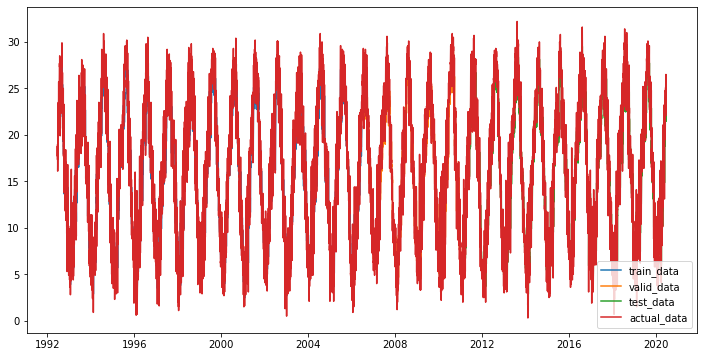

In [15]:
# グラフ化
train_predict_plot = np.empty_like(np.reshape(df_temperature.values[:, 0], (len(df_temperature), 1)))
train_predict_plot[:, :] = np.nan
idx_train_predict = look_back+len(train_predict)
train_predict_plot[look_back:idx_train_predict, :] = train_predict

valid_predict_plot = np.empty_like(np.reshape(df_temperature.values[:, 0], (len(df_temperature), 1)))
valid_predict_plot[:, :] = np.nan
idx_valid_predict = look_back+idx_train_predict + len(valid_predict)
valid_predict_plot[look_back+idx_train_predict:idx_valid_predict, :] = valid_predict

test_predict_plot = np.empty_like(np.reshape(df_temperature.values[:, 0], (len(df_temperature), 1)))
test_predict_plot[:, :] = np.nan
test_predict_plot[look_back+idx_valid_predict:, :] = test_predict
         
actual_plot = df_temperature.values[:, 0]

fig, ax = plt.subplots(1,1, figsize=(12, 6))
ax.plot(df_temperature.index, train_predict_plot, label='train_data')
ax.plot(df_temperature.index, valid_predict_plot, label='valid_data')
ax.plot(df_temperature.index, test_predict_plot, label='test_data')
ax.plot(df_temperature.index, actual_plot, label='actual_data')

ax.legend(loc='lower right')
plt.show()
fig.savefig('img.png')
   

In [16]:
# 予測値と実際の値の差分
predict_data = np.full(shape=(len(df_temperature), 1), fill_value=-999)
predict_data[look_back:look_back+len(train_predict), :] = train_predict
predict_data[look_back*2+len(train_predict): look_back*2+len(train_predict)+len(valid_predict), :] = valid_predict
predict_data[look_back*3+len(train_predict)+len(valid_predict):, :] = test_predict

diff = df_temperature.values[:, 0] - predict_data[:, 0]
diff[diff>=900] = 0


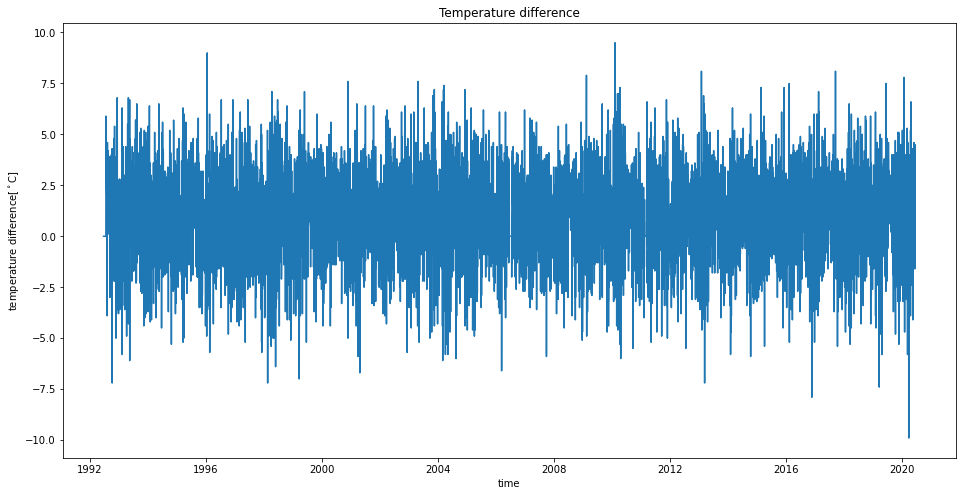

In [17]:
# プロット
fig, ax = plt.subplots(1, 1, figsize=(16,8))
ax.plot(df_temperature.index, diff)
ax.set_ylabel('temperature difference[$^\circ$C]')
ax.set_xlabel('time')
ax.set_title('Temperature difference')

plt.show()
fig.savefig('diff.png')


In [18]:
# 誤差平均、不偏標準偏差、誤差最大/最小
diff_mean = np.mean(diff)
diff_std = np.std(diff, ddof=1)
diff_max = np.max(abs(diff))
diff_min = np.min(abs(diff))
print(f"mean: {diff_mean}")
print(f"std: {diff_std}")
print(f"max: {diff_max}")
print(f"min: {diff_min}")

mean: 1.0384043801329683
std: 1.988098812578908
max: 9.9
min: 0.0


■予測結果からずれの大きい日を確認し、誤差要因を考察する

In [19]:
def create_large_diff(lim_num=7):
    acutual_large_diff = df_temperature.values[np.where(abs(diff)>=lim_num)]
    predict_large_diff = predict_data[np.where(abs(diff)>=lim_num)]
    large_diff_abs = abs(diff[np.where(abs(diff)>=lim_num)])
    day = df_temperature.index.values[np.where(abs(diff)>=lim_num)]
                                           
    df_large_diff = pd.DataFrame({'day': day,
                                  'acutual': acutual_large_diff[:, 0],
                                  'predict': predict_large_diff[:, 0],
                                  'diff_abs': large_diff_abs})

    df_large_diff = df_large_diff.sort_values('diff_abs', ascending=False).reset_index(drop=True)

    season = []
    month = []

    for i in range(len(df_large_diff)):
        tmp_month = df_large_diff.iloc[i, 0].month
        month.append(tmp_month)
        if tmp_month >= 3 and tmp_month <= 5:
            season.append("spring")
        elif tmp_month >= 6 and tmp_month <= 8:
            season.append("summer")
        elif tmp_month >= 9 and tmp_month <= 11:
            season.append('autumn')
        else:
            season.append('winter')
        
    df_large_diff['season'] = season
    df_large_diff['month'] = month
    
    return df_large_diff 

df_large_diff = create_large_diff()


In [20]:
df_large_diff

,day,acutual,predict,diff_abs,season,month
0,2020-03-29,4.1,14,9.9,spring,3
1,2010-02-09,15.5,6,9.5,winter,2
2,1996-01-15,16.0,7,9.0,winter,1
3,2017-09-18,27.1,19,8.1,autumn,9
4,2013-02-02,15.1,7,8.1,winter,2
5,2016-11-24,3.1,11,7.9,autumn,11
6,2009-02-14,17.9,10,7.9,winter,2
7,2020-01-29,12.8,5,7.8,winter,1
8,2000-11-21,17.6,10,7.6,autumn,11
9,2003-04-26,21.6,14,7.6,spring,4


In [21]:
df_large_diff.groupby(['season', 'month']).count()

day  acutual  predict  diff_abs
season month                                 
autumn 9        1        1        1         1
       10       1        1        1         1
       11       3        3        3         3
spring 3        8        8        8         8
       4        3        3        3         3
       5        1        1        1         1
summer 6        1        1        1         1
winter 1        2        2        2         2
       2        7        7        7         7
       12       2        2        2         2

In [22]:
(len(df_large_diff[df_large_diff['month']==2]) + len(df_large_diff[df_large_diff['month']==3]))/len(df_large_diff)

0.5172413793103449

誤差が7度以上だった月のうち、2・3月が51%を占めている。

In [23]:
for s in ['spring', 'summer', 'autumn', 'winter']:
    print(f"{s}: {len(df_large_diff[df_large_diff['season']==s])}")


spring: 12
summer: 1
autumn: 5
winter: 11


In [24]:
(len(df_large_diff[df_large_diff['season']=="spring"]) + len(df_large_diff[df_large_diff['season']=="winter"]))/len(df_large_diff)

0.7931034482758621

誤差が7度以上だった季節のうち、春と冬が79%を占めている。

In [25]:
df_large_diff = create_large_diff(lim_num=5)
df_large_diff.groupby(['season', 'month']).count()

day  acutual  predict  diff_abs
season month                                 
autumn 9       12       12       12        12
       10      20       20       20        20
       11      22       22       22        22
spring 3       43       43       43        43
       4       39       39       39        39
       5       27       27       27        27
summer 6       14       14       14        14
       7       14       14       14        14
       8        8        8        8         8
winter 1       11       11       11        11
       2       29       29       29        29
       12      21       21       21        21

In [26]:
(len(df_large_diff[df_large_diff['month']==2]) +
 len(df_large_diff[df_large_diff['month']==3]) +
 len(df_large_diff[df_large_diff['month']==4]) +
 len(df_large_diff[df_large_diff['month']==5]))/len(df_large_diff)

0.5307692307692308

誤差が5度以上だった月のうち、2～5月までが53%を占めている。

In [27]:
for s in ['spring', 'summer', 'autumn', 'winter']:
    print(f"{s}: {len(df_large_diff[df_large_diff['season']==s])}")


spring: 109
summer: 36
autumn: 54
winter: 61


In [28]:
(len(df_large_diff[df_large_diff['season']=="spring"]))/len(df_large_diff)

0.41923076923076924

誤差が5度以上だった季節のうち、春が42%を占めている。

誤差の大きい日の前後の温度を確認する

In [29]:
def plot_day_front_back(df, day, save_fig_name, len=7):
    t = day-datetime.timedelta(days=len)
    actual_temperature_list = []
    days_list = []
    pred_temperature_list = []
    for i in range(len*2+1):
        actual_temperature_list.append(df.loc[t, df.columns[0]])
        days_list.append(t)
        idx = (t-df.index[0]).days
        
        if idx < 0 or idx >= df.shape[0]:
            continue
        if idx >= look_back and idx < idx_train_predict:
            pred_temperature_list.append(train_predict_plot[idx, 0])
        elif idx >= look_back+idx_train_predict and idx < idx_valid_predict:
            pred_temperature_list.append(valid_predict_plot[idx, 0])
        elif idx >= look_back+idx_valid_predict:
            pred_temperature_list.append(test_predict_plot[idx, 0])
        else:
            pred_temperature.append(0)
            
        t += datetime.timedelta(days=1)    
    
    fig, ax= plt.subplots(1, 1, figsize=(16,8))
    ax.plot(days_list, actual_temperature_list, label="actual", color="blue")
    ax.plot(days_list, pred_temperature_list, label="predict", color="orange")
    ax.set_ylabel('temperature[$^\circ$C]')
    ax.axvline(x=day, color="red")
    ax.legend()
    ax.grid()
    ax.set_xlabel('time')
    plt.show()
    fig.savefig(save_fig_name)


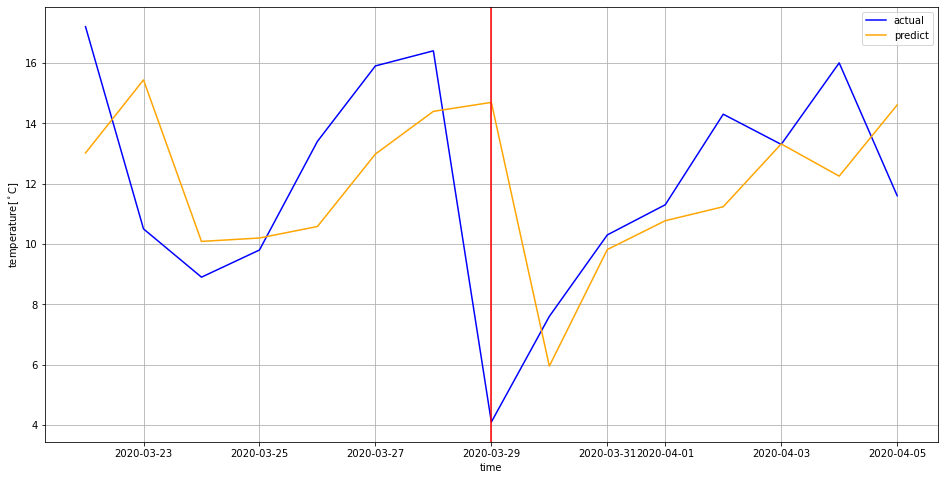

In [30]:
# 誤差1位
plot_day_front_back(df_temperature, df_large_diff.loc[0, 'day'], 'error1.png')


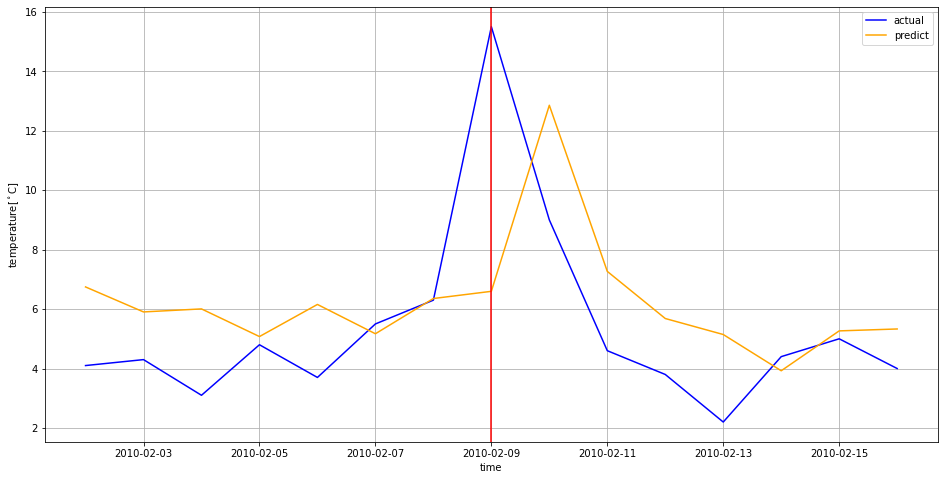

In [31]:
# 誤差2位
plot_day_front_back(df_temperature, df_large_diff.loc[1, 'day'], 'error2.png')

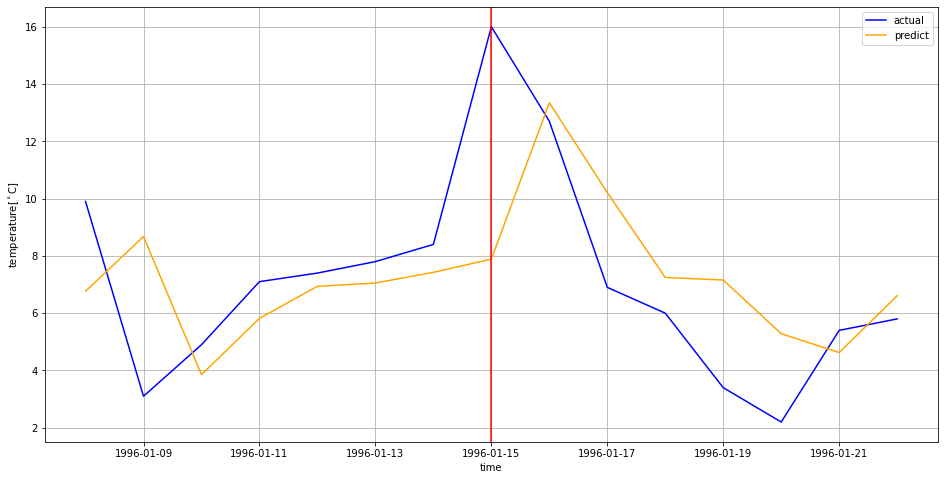

In [32]:
# 誤差3位
plot_day_front_back(df_temperature, df_large_diff.loc[2, 'day'], 'error3.png')

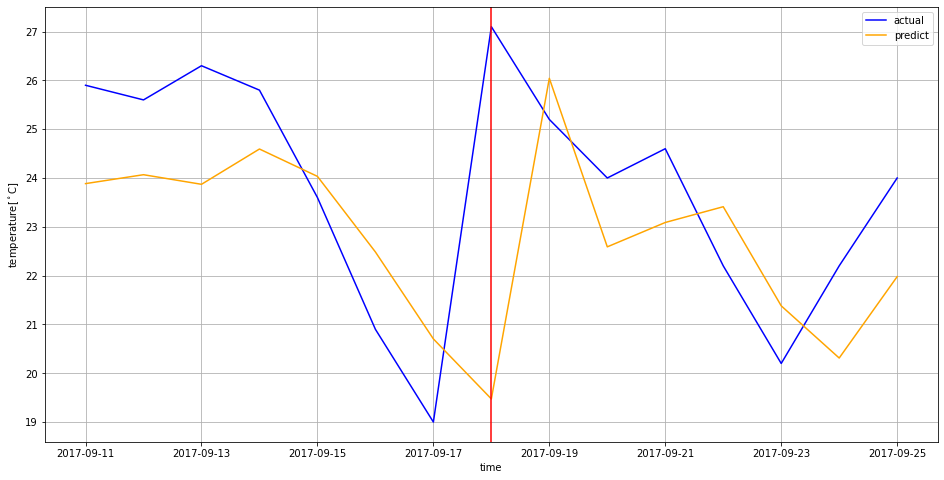

In [33]:
# 誤差4位
plot_day_front_back(df_temperature, df_large_diff.loc[3, 'day'], 'error4.png')

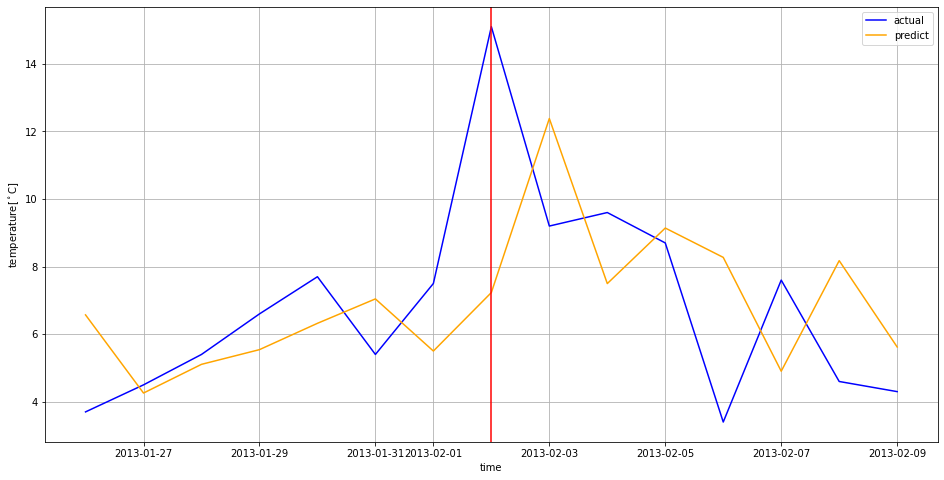

In [34]:
# 誤差5位
plot_day_front_back(df_temperature, df_large_diff.loc[4, 'day'], 'error5.png')

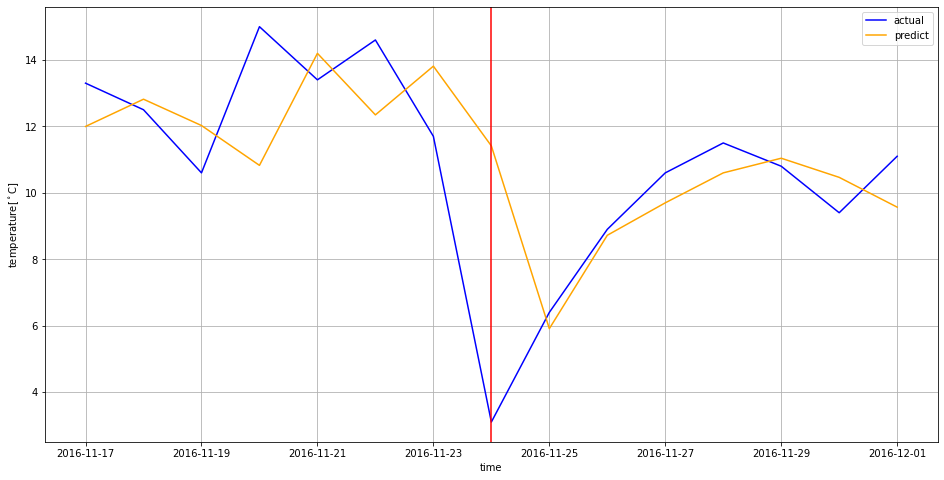

In [35]:
# 誤差6位
plot_day_front_back(df_temperature, df_large_diff.loc[5, 'day'], 'error6.png')

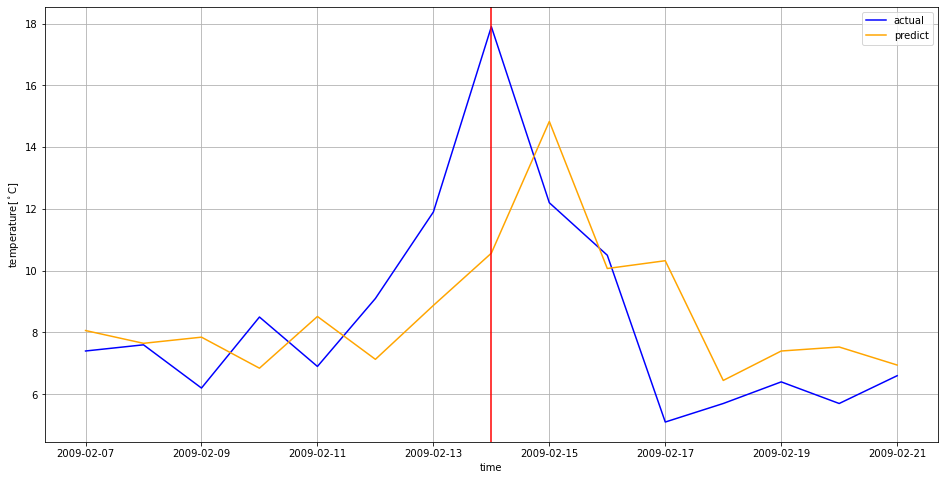

In [36]:
# 誤差7位
plot_day_front_back(df_temperature, df_large_diff.loc[6, 'day'], 'error7.png')

急激な温度変化に追随できていないことがわかる。<br>